In [1]:
import os, sys

# First find package in installation
try:
    from graphenemodeling import graphene
    from graphenemodeling import fundamental_constants as fc
# if not, use local package in this repo
except:
    gm_path=os.path.join(os.path.dirname(os.getcwd()))
    sys.path.append(gm_path)
    from graphenemodeling import graphene
    from graphenemodeling import fundamental_constants as fc
    
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Isolated Nanoribbon

## Mode Dispersion

The dispersion of modes follows the following dispersion relation

$$
\frac{\omega W}{2\pi}\text{Im}\left\{-\frac{\bar\epsilon(\omega)}{\sigma(\omega)}\right\}=\pi-\phi
$$

where $W$ is the ribbon width, $\phi=0.3\pi$, $\bar\epsilon=\epsilon_0(1+\epsilon_{\text{SiO}_2})/2$.

We want to find the dispersion in terms of $k$, and this is given by $\text{Re}[k]=(\pi-\phi)/W$. We will fix $\omega$ and calculate $k$, then take the whaaa? Inserting this gives

$$
\frac{\omega (\pi-\phi)}{2\pi\text{Re}[k]}\text{Im}\left\{-\frac{\bar\epsilon(\omega)}{\sigma(\omega)}\right\}=\pi-\phi
\\
\frac{\omega}{2\pi}\text{Im}\left\{-\frac{\bar\epsilon(\omega)}{\sigma(\omega)}\right\}=\text{Re}[k]
$$

In [2]:
def GNRdisp(omega,eps_sub,eps_sup,gamma,eFermi,T):
    mlg=graphene.Monolayer()
    
    sigma=mlg.OpticalConductivity(q=0,omega=omega,gamma=gamma,eFermi=eFermi,T=T)
    epsilon_sub=eps_sub(omega)
    bareps=(eps_sup+epsilon_sub)/2
    
    return (omega/2*np.pi)*np.imag(-fc.epsilon_0*bareps/sigma)

In [3]:
def eps_sio2(omega):
    eVtoAngFreq=2*np.pi*241.8*1e12
    eps_inf=2.11
    omega0=0.111*eVtoAngFreq # rad/s
    omegar=0.132*eVtoAngFreq # eV
    Gamma=0.00882*eVtoAngFreq # eV
    
    LorentzTerm = omega0**2 / ((omega**2 - omegar**2)+1j*Gamma*omega)
    return (eps_inf - LorentzTerm )

eps_ps=2.46+1j*0.00157

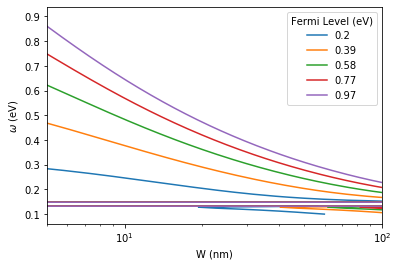

In [5]:
eVtoAngFreq=2*np.pi*241.8*1e12
g=0.01*fc.e_proton
omega=np.linspace(0.1,0.9,200)*eVtoAngFreq
np.savetxt(os.path.join('data','omega.txt'),omega)
eF_arr=np.array([0.2021,0.387,0.5833,0.774,0.969])*fc.e_proton

for eF in eF_arr:
    kp=GNRdisp(omega,eps_sio2,1,g,eF,T=0)
    W = (np.pi-0.35*np.pi) / kp
    plt.semilogx(W*1e9,omega/eVtoAngFreq,label=round(eF/fc.e_proton,2))
    savefile=os.path.join('data','W_'+str(round(eF/fc.e_proton,2))+'.txt')
    np.savetxt(savefile,W)
    
plt.xlabel('W (nm)')
plt.ylabel('$\omega$ (eV)')
plt.xlim(5,100)
plt.legend(title='Fermi Level (eV)')
plt.show()

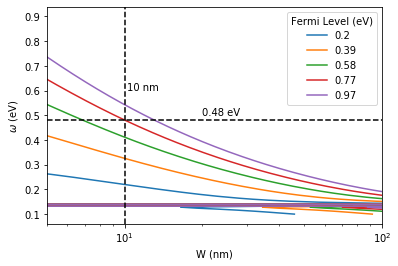

In [6]:
eVtoAngFreq=2*np.pi*241.8*1e12
omega=np.linspace(0.1,0.9,200)*eVtoAngFreq
np.savetxt(os.path.join('data','omega.txt'),omega)
eF_arr=np.array([0.2021,0.387,0.5833,0.774,0.969])*fc.e_proton

for eF in eF_arr:
    kp=GNRdisp(omega,eps_sio2,eps_ps,g,eF,T=0)
    W = (np.pi-0.35*np.pi) / kp
    plt.semilogx(W*1e9,omega/eVtoAngFreq,label=round(eF/fc.e_proton,2))
    savefile=os.path.join('data','W_'+str(round(eF/fc.e_proton,2))+'_ps.txt')
    np.savetxt(savefile,W)
    
    if round(eF/fc.e_proton,2)==0.77:
        dotarg=np.argmin(np.abs(10-W*1e9))
        dotomega=omega[dotarg]/eVtoAngFreq

plt.axvline(10,color='k',linestyle='dashed')
plt.text(10.2,0.6,'10 nm')
plt.axhline(dotomega,color='k',linestyle='dashed')
plt.text(20,0.5,'0.48 eV')
plt.xlabel('W (nm)')
plt.ylabel('$\omega$ (eV)')
plt.xlim(5,100)
plt.legend(title='Fermi Level (eV)')
plt.show()

In [7]:
def GNRdisp2(eFermi,eps_sub,eps_sup,gamma,W,T,phi):
    eVtoAngFreq=2*np.pi*241.8*1e12
    omega=np.linspace(0.005,0.9,10000)*eVtoAngFreq
    
    omega_result=[]
    
    for eF in eFermi[::-1]:
        kTemp=GNRdisp(omega,eps_sub,eps_sup,gamma,eF,T)
        WTemp = (np.pi-phi*np.pi) / kTemp
        Warg=np.argmin(np.abs(W-WTemp))
        
        omega_result.append(omega[Warg])
        
        omega = np.linspace(.95,1.05,100)*omega_result[-1]
        
    return np.array(omega_result)[::-1]
        

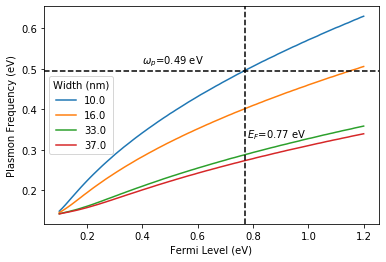

In [9]:
eFermi=np.linspace(0.1,1.2,100)*fc.e_proton
W_arr=np.array([10,16,33,37])*1e-9

for W in W_arr:
    omega_ef=GNRdisp2(eFermi,eps_sio2,eps_ps,g,W,T=0,phi=0.3)/eVtoAngFreq
    plt.plot(eFermi/fc.e_proton,omega_ef,label=str(round(W*1e9)))
    if W==10e-9:
        dotarg=np.argmin(np.abs(0.77-eFermi/fc.e_proton))
        dotomega=omega_ef[dotarg]

    
plt.axvline(0.77,color='k',linestyle='dashed')
plt.text(0.78,0.33,'$E_F$=0.77 eV')
plt.axhline(dotomega,color='k',linestyle='dashed')
plt.text(0.4,dotomega+0.02,'$\omega_p$='+str(round(dotomega,2))+' eV')
plt.xlabel('Fermi Level (eV)')
plt.ylabel('Plasmon Frequency (eV)')
plt.legend(title='Width (nm)')
plt.show()

In [11]:
eFermi=np.linspace(0.05,1.2,100)*fc.e_proton
W_arr2=np.array([10,12,14,13,15,17,16,18,20,33,35,37])*1e-9

for W in W_arr2:
    omega_ef=GNRdisp2(eFermi,eps_sio2,eps_ps,g,W,T=0,phi=0.3)/eVtoAngFreq
    savefile=os.path.join('data','plasmonfrequency_ribbonwidth_'+str(int(round(W*1e9,2)))+'nm_phi_3.txt')
    np.savetxt(savefile,omega_ef)

savefile=os.path.join('data','fermilevels_plasmonfrequency_ribbon.txt')
np.savetxt(savefile,eFermi/fc.e_proton)

## Local Response Approximation (LRA)

Description from [Christensen 2017, 5.3.1](http://link.springer.com/10.1007/978-3-319-48562-1):

In nanostructured graphene ($\mathbf r_{||}\in\Omega$ in the $xy$-plane), one may self-consitently couple Coulomb's law to the continuity equation for charge to find

$$
\phi(\mathbf r_{||})=\int_\Omega \frac{\rho_{||}(\mathbf r_{||}}{4\pi\epsilon_0\bar\epsilon|\mathbf{r_{||}-r'_{||}}|} d^2\mathbf r_{||} \\
\rho_{||}(\mathbf r_{||}) =i\omega^{-1}\nabla_{||}\cdot[\sigma(\mathbf r_{||},\omega)\nabla_{||}\phi(\mathbf r_{||})]
$$

Then the potential $\phi$ (or equivalently the charge density) can be decomposed into eigenstates $\left|\phi_\nu\right>$ with eigenvalues

$$
\zeta_\nu \phi_\nu(\mathbf r_{||})=\frac{-1}{2\pi}\int_{\bar\Omega} ... \\
\zeta_\nu = \frac{2 i \epsilon_0\bar\epsilon\omega_\nu L}{\sigma(\omega_\nu)}
$$

<img src='images/christensen-thesis-2017-fig5-6.png' width='500px'/>

## Hydrodynamic Model (HDM)

The Green function from [Cautadella 1986](https://link.aps.org/doi/10.1103/PhysRevB.35.7443) as corrected by [Christensen 2017](http://link.springer.com/10.1007/978-3-319-48562-1)

$$
G(x,x')=\frac{1}{2q}\left\{ e^{-q|x-x'|} + \frac{e^{-q}\cosh[q(x-x')]+\cosh[q(x+x')]}{\sinh q} \right\}
$$

# Nanoribbon Array

# Bounds on Optical Response

[Miller et al. 2017](http://pubs.acs.org/doi/10.1021/acs.nanolett.7b02007) describes what is possible for the optical response of various 2D materials. They find that for a 2D scatterer with local conductivity $\overleftrightarrow\sigma(\omega)$, the optical response is bounded by, what they entitle, a *material figure or merit* given by

$$
\text{Material FOM:   }F=Z_0||\overleftrightarrow\sigma^\dagger(\text{Re}[\overleftrightarrow\sigma])^{-1}\overleftrightarrow\sigma||_2
$$

where  $||.||_2$ is the *induced matrix 2-norm*. The cross sections $\sigma_\alpha$ are found to be bounded by
$$
\boxed{
    \sigma_{sca}/A \leq \frac{1}{4}F\\
    \sigma_{abs}/A \leq  F\\
    \sigma_{ext}/A \leq  F\\
}
$$


They identify graphene as one of the best in the mid-infrared and optical region of the EM spectrum (along with silver). Here, we attempt to replicate their results for graphene using the `Graphene.Nanostructure` class. For comparisons to other materials, see [this notebook] 

(They don't explicitly state the parameters used in Figure 1, but in later calculations, they use $T=300$ K and $\gamma$=($10^{12}$ eV/s)/$\epsilon_F$. Using those parameters, our results match)

In [2]:
mlg_nano = Graphene.Nanostructure(1)

eF = 0.6*fc.e_proton
omega = np.linspace(.1,2,num=100)*fc.e_proton /fc.hbar
gamma = lambda eF: 10**12 * fc.e_proton / eF
T=300

bound_gr_high = mlg_nano.OpticalResponseBound(omega,gamma(0.6*fc.e_proton),0.6*fc.e_proton,T)
#bound_gr_mid = mlg_nano.OpticalResponseBound(omega,gamma(0.4*fc.e_proton),0.4*fc.e_proton,T)
#bound_gr_low = mlg_nano.OpticalResponseBound(omega,gamma(0.2*fc.e_proton),0.2*fc.e_proton,T)

C:\Users\User\Documents\Research\Notes\code\Graphene.py:1502: UserWarning: Nanostructure.OpticalResponseBound: Only MONOLAYER is being used.
  warnings.warn("Nanostructure.OpticalResponseBound: Only MONOLAYER is being used.")


UnboundLocalError: local variable 'LDOSprop' referenced before assignment

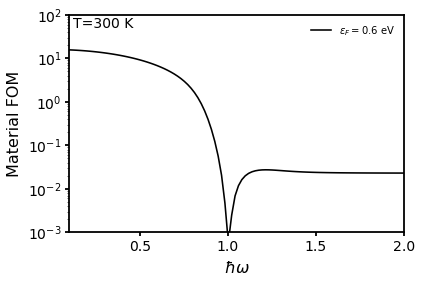

In [3]:
plt.semilogy(omega*fc.hbar/fc.e_proton,bound_gr_high,color='black',label='$\epsilon_F=0.6$ eV')
#plt.semilogy(omega*fc.hbar/fc.e_proton,bound_gr_mid,color='royalblue',label='$\epsilon_F=0.4$ eV')
#plt.semilogy(omega*fc.hbar/fc.e_proton,bound_gr_low,color='darkgreen',label='$\epsilon_F=0.2$ eV')
plt.xlabel('$\hbar\omega$')
plt.ylabel('Material FOM')
plt.ylim(1e-3,1e2)
plt.xlim(0.1,2)
plt.text(0.12,5*10**1,'T=%d K' %(T),fontsize=14)
plt.legend()
plt.show()

<img src='images/miller-limits-2017-fig1.png' width='400px'/>